In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Train image')

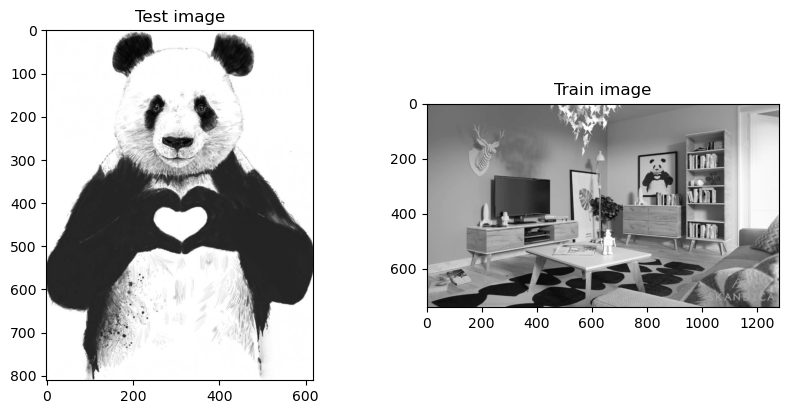

In [3]:
MIN_MATCH_COUNT = 10
img1 = cv.imread('photo_2_query.jpg', cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('photo_2_train.jpg', cv.IMREAD_GRAYSCALE) # trainImage

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(img1, cmap = 'gray')
plt.title('Test image')

plt.subplot(2,2,2)
plt.imshow(img2, cmap = 'gray')
plt.title('Train image')

In [4]:
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h, w = img1.shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)
    img2 = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

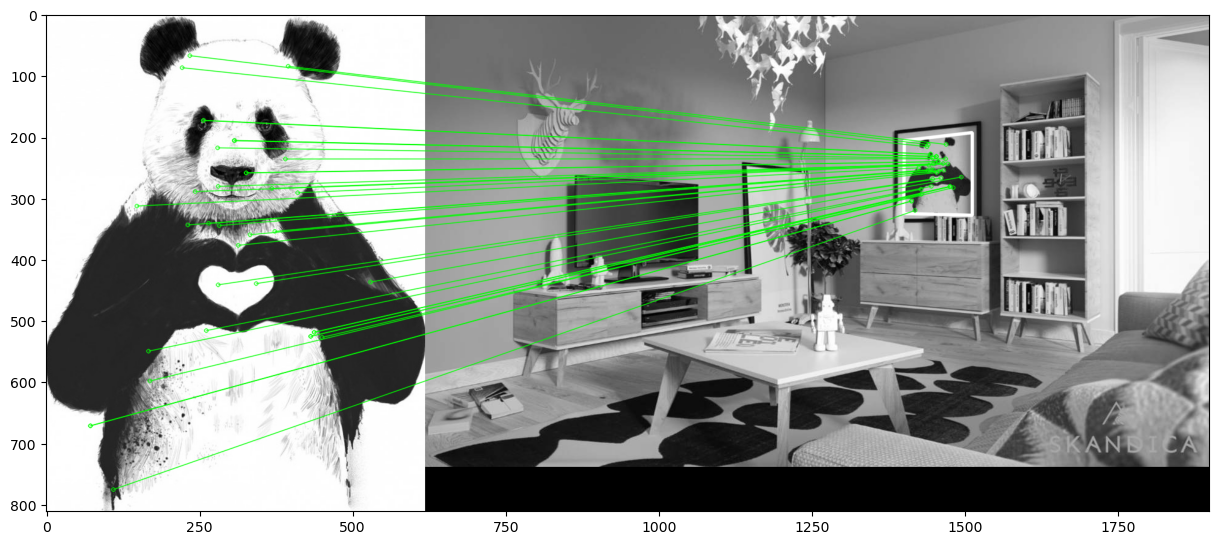

In [5]:
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.figure(figsize=(15, 15)) 
plt.imshow(img3, 'gray')
plt.show()
#cv.imwrite("2_findHomography.jpg", img3)